## Predicting Crime Categories

#### Import statements

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from seaborn import heatmap
from sklearn import tree
import seaborn as sns
from keras.models import Sequential

#### Importing train data 

In [2]:
df_train_origin = pd.read_csv("train.csv")
print(df_train_origin.head())
print(len(df_train_origin))

                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.4387

#### Importing test data 

In [3]:
df_test_origin = pd.read_csv("test.csv")
#print(df_test_origin)

#### Information about the data

In [4]:
df_train_origin.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [5]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


#### Check whether zero values are contained

In [6]:
df_train_origin.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

#### Detecting outliers

In [7]:
#GPS of San Francisco
#• Breitengrad von San Francisco:
    #37.7562
#• Längengrad von San Francisco:
    #-122.4430
#• GPS Koordinaten von San Francisco:
    #37° 45‘ 22.32 N 122° 26‘ 34.8 W

coordinates_range = ((df_train_origin.X.min(),   df_train_origin.X.max(),
         df_train_origin.Y.min(), df_train_origin.Y.max()))

print(coordinates_range)

sum = 0
for i in df_train_origin.index:
    if df_train_origin["Y"][i] > 37.9:
        sum +=1
print("sum of Y coordinates outside San Francisco: ", sum)

(-122.51364206429, -120.5, 37.7078790224135, 90.0)
sum of Y coordinates outside San Francisco:  67


#### Check for duplicates

In [8]:
duplicated = df_train_origin[df_train_origin.duplicated()]
len(duplicated)

2323

#### Cleaning data

In [9]:
#remove all records that are not located in San Francisco

df_train_origin = df_train_origin[df_train_origin["Y"] < 38]

df_test_origin = df_test_origin[df_test_origin["Y"] < 38]

#remove duplicated rows!!!
df_train_origin = df_train_origin.drop_duplicates()

#878049
print(len(df_train_origin))

875659


In [10]:
df_train_origin.groupby([df_train_origin['Category']]).size()

Category
ARSON                            1512
ASSAULT                         76811
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36599
DISORDERLY CONDUCT               4311
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53919
DRUNKENNESS                      4277
EMBEZZLEMENT                     1164
EXTORTION                         256
FAMILY OFFENSES                   488
FORGERY/COUNTERFEITING          10592
FRAUD                           16637
GAMBLING                          146
KIDNAPPING                       2340
LARCENY/THEFT                  174305
LIQUOR LAWS                      1899
LOITERING                        1207
MISSING PERSON                  25669
NON-CRIMINAL                    91911
OTHER OFFENSES                 125943
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7446
RECOVERED VEHICLE                3132
ROBBERY                         22987
RUN

#### Mapping of column category (as our "Y")

In [11]:
#all different categories
pd.unique(df_train_origin["Category"])

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [12]:
#mapping perhaps better with df.factorize()
'''
dict_category = {}
index = 1
for i in pd.unique(df_train_origin["Category"]):
    val = {i : index}
    dict_category.update(val)
    index+=1

print(dict_category)
'''

'\ndict_category = {}\nindex = 1\nfor i in pd.unique(df_train_origin["Category"]):\n    val = {i : index}\n    dict_category.update(val)\n    index+=1\n\nprint(dict_category)\n'

In [13]:
'''
#mapped column "Category"
Y_df = df_train_origin["Category"].map(dict_category).fillna(df_train_origin["Category"]).astype(int) # categories
'''

'\n#mapped column "Category"\nY_df = df_train_origin["Category"].map(dict_category).fillna(df_train_origin["Category"]).astype(int) # categories\n'

In [14]:
#with factorized
Y_df = pd.factorize(df_train_origin["Category"])
print(Y_df)

(array([ 0,  1,  1, ...,  2,  4, 12], dtype=int64), Index(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS', 'FORGERY/COUNTERFEITING',
       'DRUG/NARCOTIC', 'STOLEN PROPERTY', 'SECONDARY CODES', 'TRESPASS',
       'MISSING PERSON', 'FRAUD', 'KIDNAPPING', 'RUNAWAY',
       'DRIVING UNDER THE INFLUENCE', 'SEX OFFENSES FORCIBLE', 'PROSTITUTION',
       'DISORDERLY CONDUCT', 'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS',
       'BRIBERY', 'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype='object'))


#### Mapping of column weekday (as a part of "X")

In [15]:
#mapping perhaps better with df.factorize()
'''
#all different weekdays
pd.unique(df_train_origin["DayOfWeek"])
'''

'\n#all different weekdays\npd.unique(df_train_origin["DayOfWeek"])\n'

In [16]:
'''
#dict weekday
dict_weekday = {"Monday" : 1, "Tuesday" : 2, "Wednesday" : 3, "Thursday" : 4, "Friday" : 5, "Saturday" : 6, "Sunday" : 7 }
print(dict_weekday)
'''

'\n#dict weekday\ndict_weekday = {"Monday" : 1, "Tuesday" : 2, "Wednesday" : 3, "Thursday" : 4, "Friday" : 5, "Saturday" : 6, "Sunday" : 7 }\nprint(dict_weekday)\n'

In [17]:
'''
#mapped column "DayOfWeek"
weekdays = df_train_origin["DayOfWeek"].map(dict_weekday).fillna(df_train_origin["DayOfWeek"]).astype(int)
'''

'\n#mapped column "DayOfWeek"\nweekdays = df_train_origin["DayOfWeek"].map(dict_weekday).fillna(df_train_origin["DayOfWeek"]).astype(int)\n'

In [18]:
#with factorize
weekdays = pd.factorize(df_train_origin["DayOfWeek"])

#### Mapping of column PdDistrict (as a part of "X")

In [19]:
#mapping perhaps better with df.factorize()
'''
#all different police department district
pd.unique(df_train_origin["PdDistrict"])
'''

'\n#all different police department district\npd.unique(df_train_origin["PdDistrict"])\n'

In [20]:
'''
dict_PdDistrict = {}
index = 1
for i in pd.unique(df_train_origin["PdDistrict"]):
    val = {i : index}
    dict_PdDistrict.update(val)
    index+=1

print(dict_PdDistrict)
'''

'\ndict_PdDistrict = {}\nindex = 1\nfor i in pd.unique(df_train_origin["PdDistrict"]):\n    val = {i : index}\n    dict_PdDistrict.update(val)\n    index+=1\n\nprint(dict_PdDistrict)\n'

In [21]:
'''
#mapped column "Category"
pdDistricts = df_train_origin["PdDistrict"].map(dict_PdDistrict).fillna(df_train_origin["PdDistrict"]).astype(int)
'''

'\n#mapped column "Category"\npdDistricts = df_train_origin["PdDistrict"].map(dict_PdDistrict).fillna(df_train_origin["PdDistrict"]).astype(int)\n'

In [22]:
#with factorize
pdDistricts = pd.factorize(df_train_origin["PdDistrict"])

#### Mapping of all addresses (as a part of "X", perhaps not e part of X)

In [23]:
#mapping perhaps better with df.factorize()
'''
#all different Addresses -> to cluster!!!
adress = pd.unique(df_train_origin["Address"])
for a in adress:
    print(a)
'''


'\n#all different Addresses -> to cluster!!!\nadress = pd.unique(df_train_origin["Address"])\nfor a in adress:\n    print(a)\n'

In [24]:
#print(df_train_origin["Address"][::][-3:])
'''
addresses_short = []
for address in df_train_origin["Address"]:
    addresses_short.append(address[-3:])
    
addresses_short = pd.DataFrame (addresses_short, columns = ['Addresses_short'])
addresses_short.columns
'''

'\naddresses_short = []\nfor address in df_train_origin["Address"]:\n    addresses_short.append(address[-3:])\n    \naddresses_short = pd.DataFrame (addresses_short, columns = [\'Addresses_short\'])\naddresses_short.columns\n'

In [25]:
addresses = []
for address in df_train_origin["Address"]:
    if address.lower().find("block") != -1:
        addresses.append(1)
    else:
        addresses.append(0)
    

In [26]:
'''
dict_Addresses = {}
index = 1
for i in pd.unique(df_train_origin["Address"]):
    val = {i : index}
    dict_Addresses.update(val)
    index+=1

#print(dict_Addresses)
'''

'\ndict_Addresses = {}\nindex = 1\nfor i in pd.unique(df_train_origin["Address"]):\n    val = {i : index}\n    dict_Addresses.update(val)\n    index+=1\n\n#print(dict_Addresses)\n'

In [27]:
'''
#maped column "Addresses"
addresses = df_train_origin["Address"].map(dict_Addresses).fillna(df_train_origin["Address"]).astype(int)
'''

'\n#maped column "Addresses"\naddresses = df_train_origin["Address"].map(dict_Addresses).fillna(df_train_origin["Address"]).astype(int)\n'

In [28]:
#with factorize
'''
addresses = pd.factorize(addresses_short["Addresses_short"])
addresses
'''

'\naddresses = pd.factorize(addresses_short["Addresses_short"])\naddresses\n'

#### Mapping of days are in weekend

In [29]:
weekends = (df_train_origin["DayOfWeek"]== "Sunday" ) | (df_train_origin["DayOfWeek"] == "Saturday")
weekends = weekends.replace(False, 0)
weekends = weekends.replace(True, 1)

#### Converting Dates to timestamps (it is split into individual attributes for meaningful use)

In [30]:
datetimes =  pd.to_datetime(df_train_origin['Dates'])
datetimes

0        2015-05-13 23:53:00
1        2015-05-13 23:53:00
2        2015-05-13 23:33:00
3        2015-05-13 23:30:00
4        2015-05-13 23:30:00
                 ...        
878044   2003-01-06 00:15:00
878045   2003-01-06 00:01:00
878046   2003-01-06 00:01:00
878047   2003-01-06 00:01:00
878048   2003-01-06 00:01:00
Name: Dates, Length: 875659, dtype: datetime64[ns]

#### Generating mapped dataFrame (as our "X)

In [31]:
data_new = { "DayOfWeek": weekdays[0], "Weekend": weekends,
            "PdDistrict": pdDistricts[0], "Address": addresses,
            "X": df_train_origin["X"], "Y":df_train_origin["Y"] }
#"Resolution" : resolutions, "Descript": descriptions,

In [32]:
X_df = pd.DataFrame(data_new)
print(X_df)


        DayOfWeek  Weekend  PdDistrict  Address           X          Y
0               0        0           0        0 -122.425892  37.774599
1               0        0           0        0 -122.425892  37.774599
2               0        0           0        0 -122.424363  37.800414
3               0        0           0        1 -122.426995  37.800873
4               0        0           1        1 -122.438738  37.771541
...           ...      ...         ...      ...         ...        ...
878044          2        0           6        0 -122.459033  37.714056
878045          2        0           2        1 -122.447364  37.731948
878046          2        0           9        0 -122.403390  37.780266
878047          2        0           9        0 -122.390531  37.780607
878048          2        0           3        1 -122.394926  37.738212

[875659 rows x 6 columns]


In [33]:
#splitting dates in different time features
#L = ['year', 'month', 'day', 'dayofyear', 'week', 'quarter', 'hour']
L = ['year', 'month', 'quarter', 'hour']
print(L)
date_gen = (getattr(datetimes.dt, i).rename(i) for i in L)
print(date_gen)
print(X_df.columns)
X_df = X_df.join(pd.concat(date_gen, axis=1))

print(X_df)

['year', 'month', 'quarter', 'hour']
<generator object <genexpr> at 0x0000015482508D60>
Index(['DayOfWeek', 'Weekend', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')
        DayOfWeek  Weekend  PdDistrict  Address           X          Y  year  \
0               0        0           0        0 -122.425892  37.774599  2015   
1               0        0           0        0 -122.425892  37.774599  2015   
2               0        0           0        0 -122.424363  37.800414  2015   
3               0        0           0        1 -122.426995  37.800873  2015   
4               0        0           1        1 -122.438738  37.771541  2015   
...           ...      ...         ...      ...         ...        ...   ...   
878044          2        0           6        0 -122.459033  37.714056  2003   
878045          2        0           2        1 -122.447364  37.731948  2003   
878046          2        0           9        0 -122.403390  37.780266  2003   
878047          2        0   

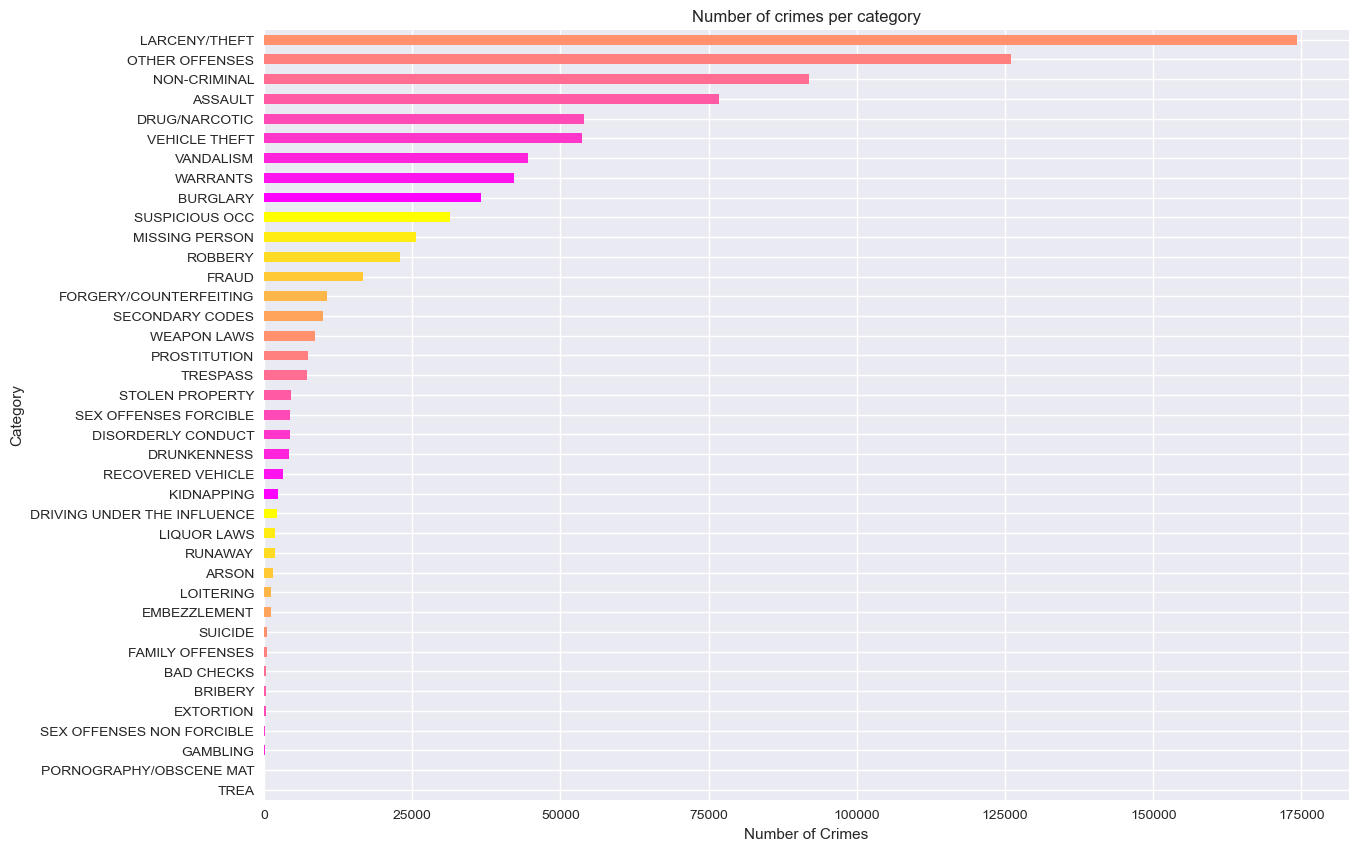

In [34]:
plt.figure(figsize=(14,10))
plt.style.use('seaborn')
plt.title('Number of crimes per category')
plt.ylabel('Category')
plt.xlabel('Number of Crimes')

color = plt.cm.spring(np.linspace(0, 1, 15))

X_df.groupby([df_train_origin['Category']]).size().sort_values(ascending=True).plot(kind='barh', color=color)

plt.show()

C:\Users\axgno01\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


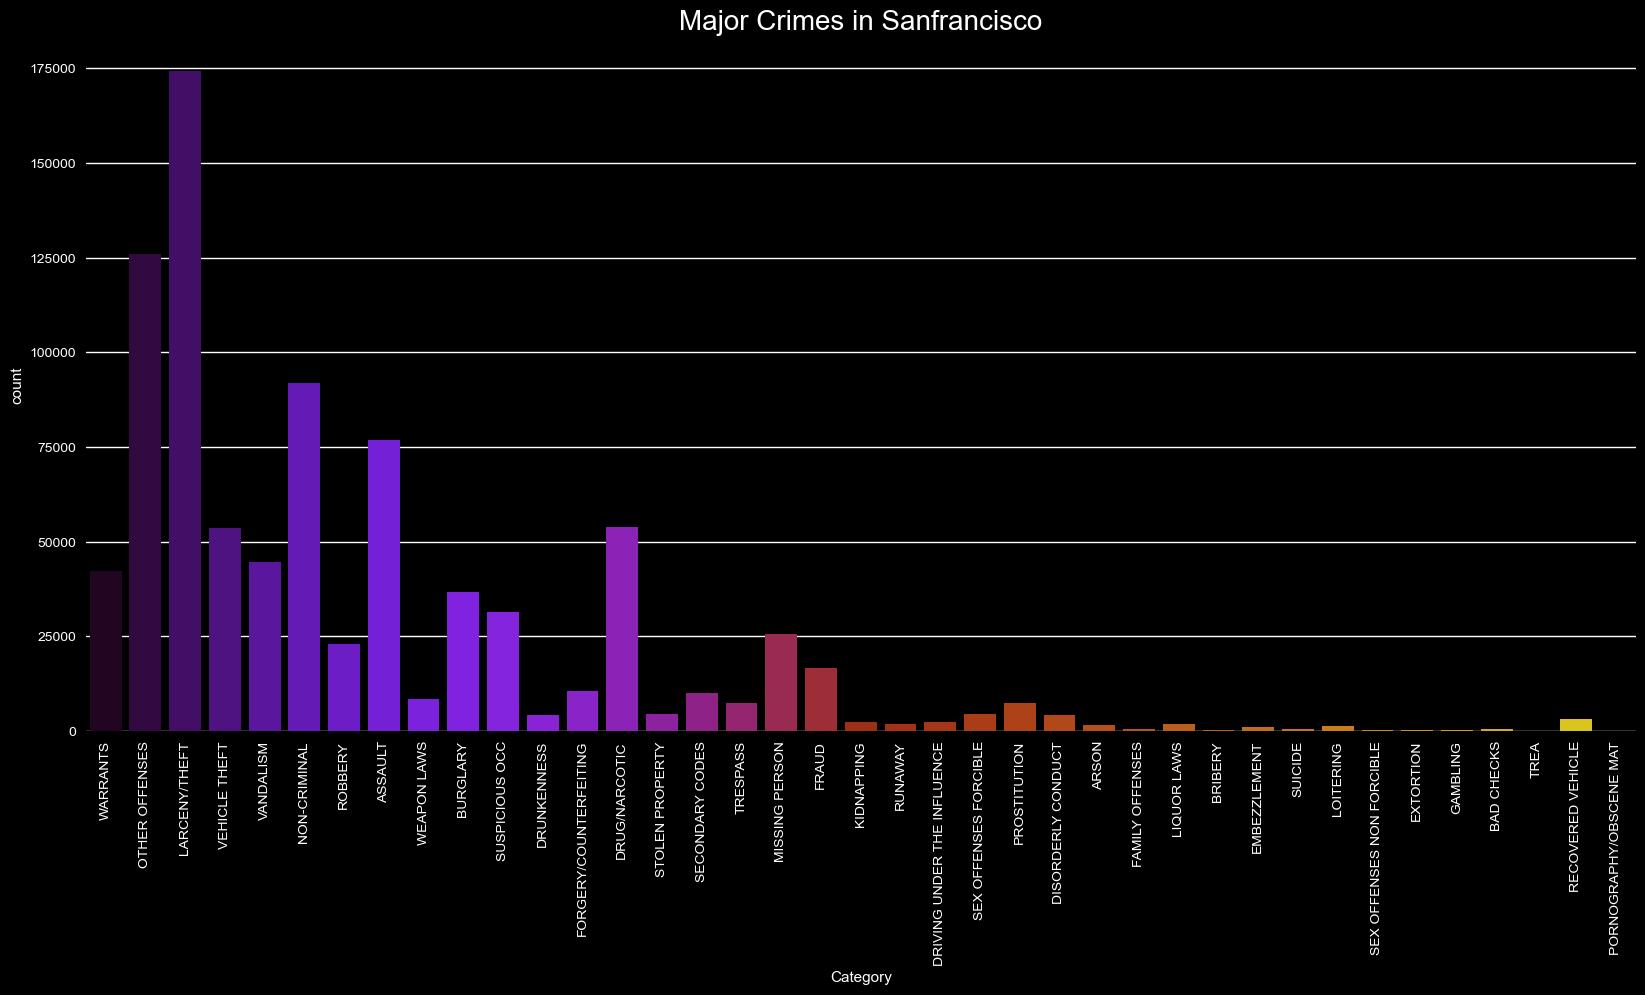

In [35]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('dark_background')

sns.countplot(df_train_origin['Category'], palette = 'gnuplot')

plt.title('Major Crimes in Sanfrancisco', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [36]:
import squarify
y = df_train_origin['Category'].value_counts().head(25)
    
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fivethirtyeight')

color = plt.cm.magma(np.linspace(0, 1, 15))
squarify.plot(sizes = y.values, label = y.index, alpha=.8, color = color)
plt.title('Tree Map for Top 25 Crimes', fontsize = 20)

plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'squarify'

In [37]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('ggplot')

wc = WordCloud(background_color = 'lightblue', width = 1500, height = 1500).generate(str(df_train_origin['Descript']))
plt.title('Description of the Crime', fontsize = 20)

plt.imshow(wc)
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [38]:
import matplotlib.cm
#plt.colormaps()

In [39]:
#plt.style.available

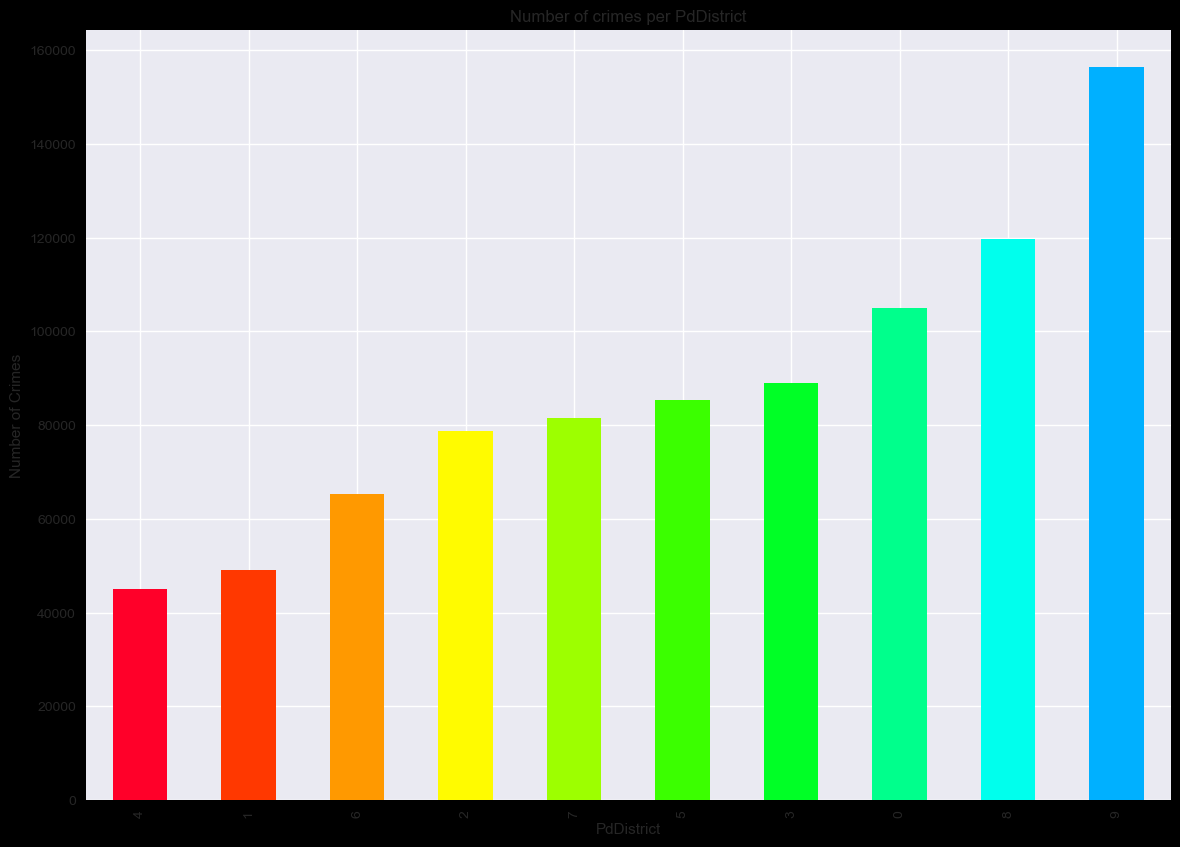

In [40]:
#Crimes per PdDistrict

plt.figure(2, figsize=(14,10))
plt.style.use('seaborn')
plt.title('Number of crimes per PdDistrict')
plt.ylabel('Number of Crimes')
plt.xlabel('PdDistrict')

color = plt.cm.gist_rainbow(np.linspace(0, 1, 15))

X_df.groupby([X_df['PdDistrict']]).size().sort_values(ascending=True).plot(kind='bar', color=color)

plt.show()

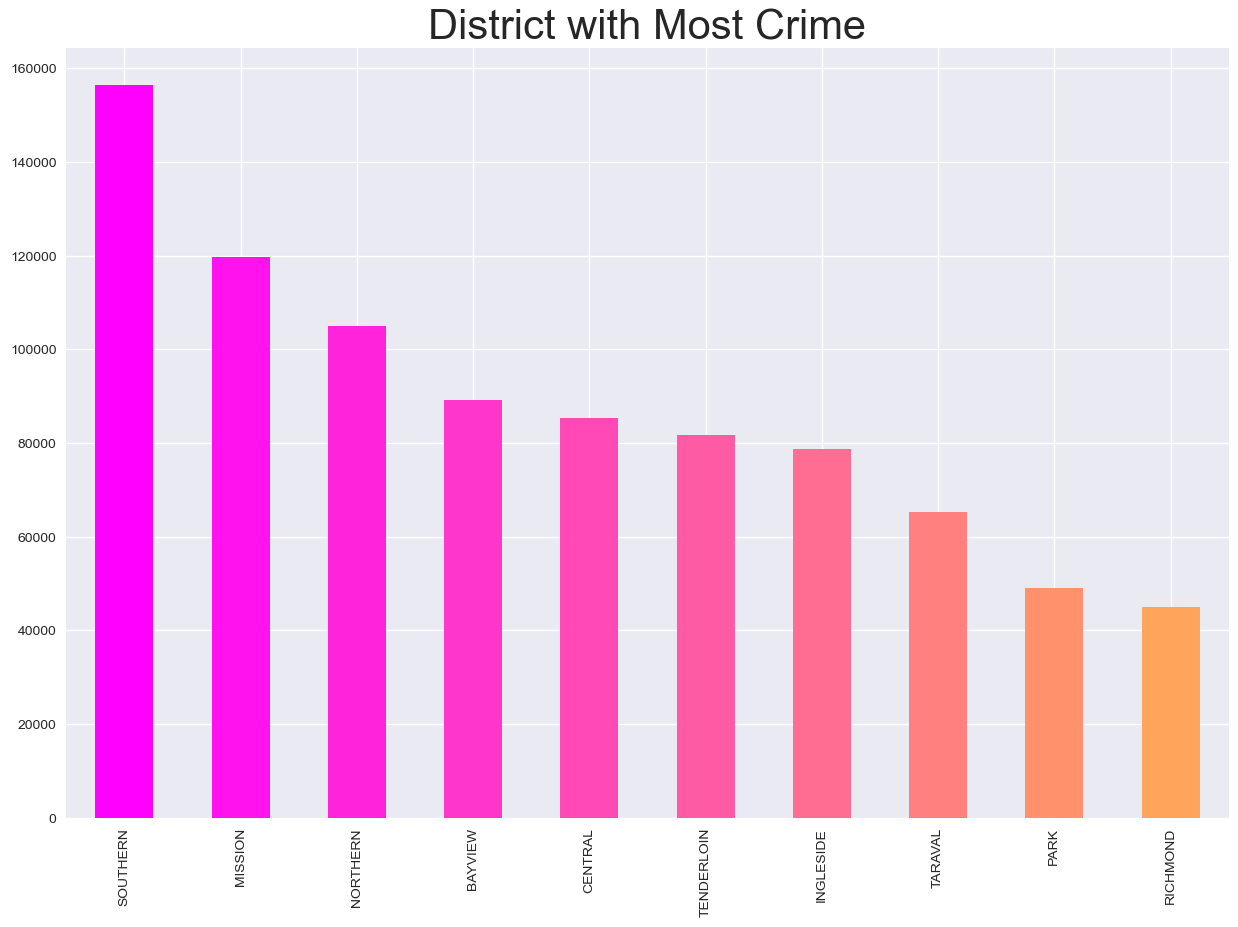

In [41]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('seaborn')

color = plt.cm.spring(np.linspace(0, 1, 15))
df_train_origin['PdDistrict'].value_counts().plot.bar(color = color, figsize = (15, 10))

plt.title('District with Most Crime',fontsize = 30)

plt.xticks(rotation = 90)
plt.show()

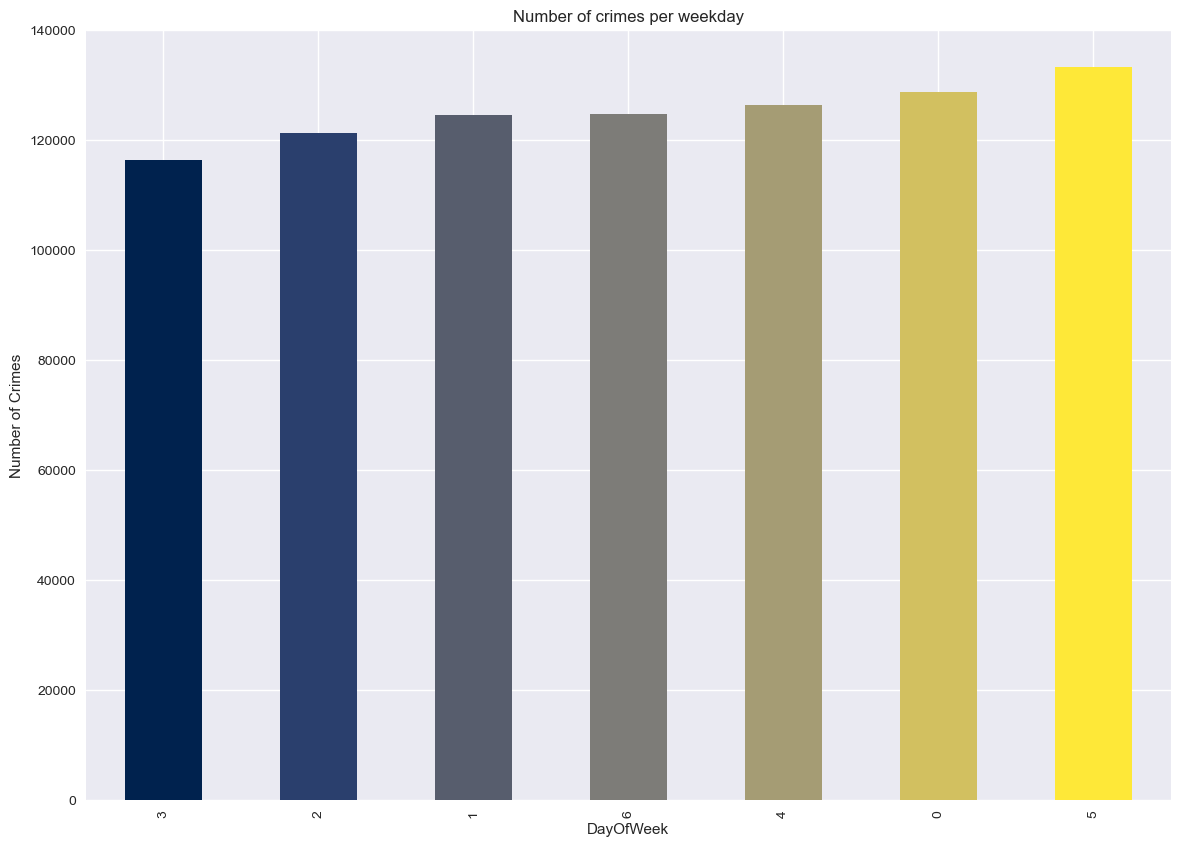

In [42]:
#Crimes per hour

plt.figure(3, figsize=(14,10))
plt.style.use('seaborn')
plt.title('Number of crimes per weekday')
plt.ylabel('Number of Crimes')
plt.xlabel('weekday')

color = plt.cm.cividis(np.linspace(0, 1, 7))

X_df.groupby([X_df['DayOfWeek']]).size().sort_values(ascending=True).plot(kind='bar', color=color)

plt.show()

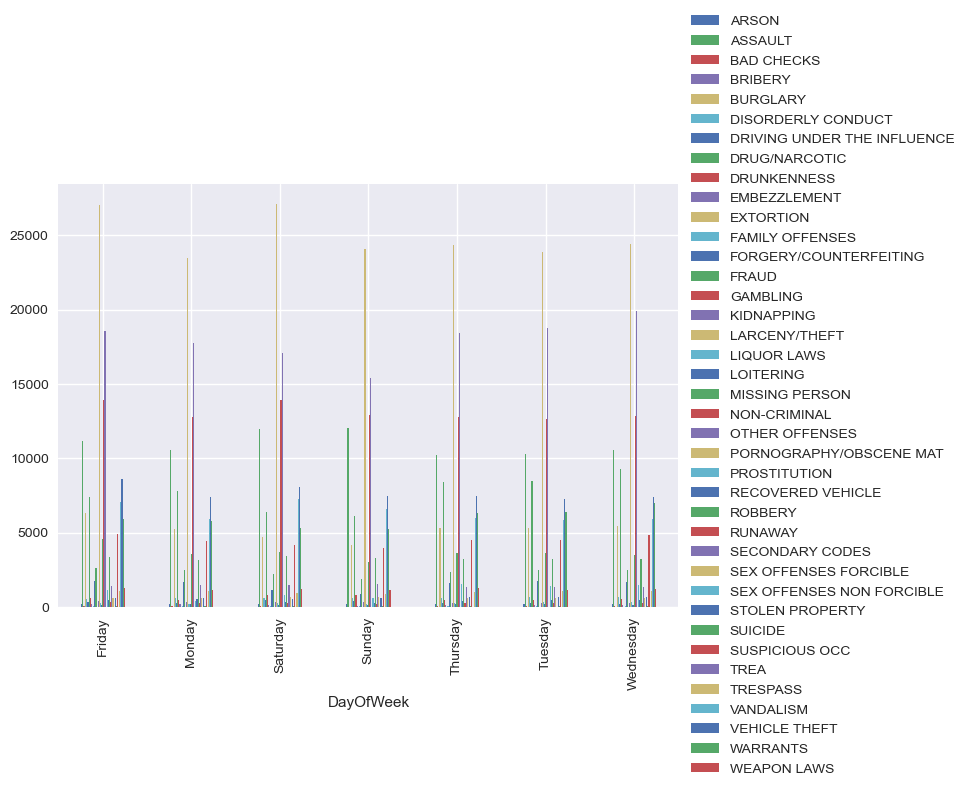

In [87]:
#Crimes per hour
#print(df_train_origin[['DayOfWeek','Category']].groupby(['DayOfWeek', 'Category']).size())
new_df = df_train_origin[['DayOfWeek','Category']].groupby(['DayOfWeek','Category']).size()
new_df = new_df
new_df.unstack('Category').plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

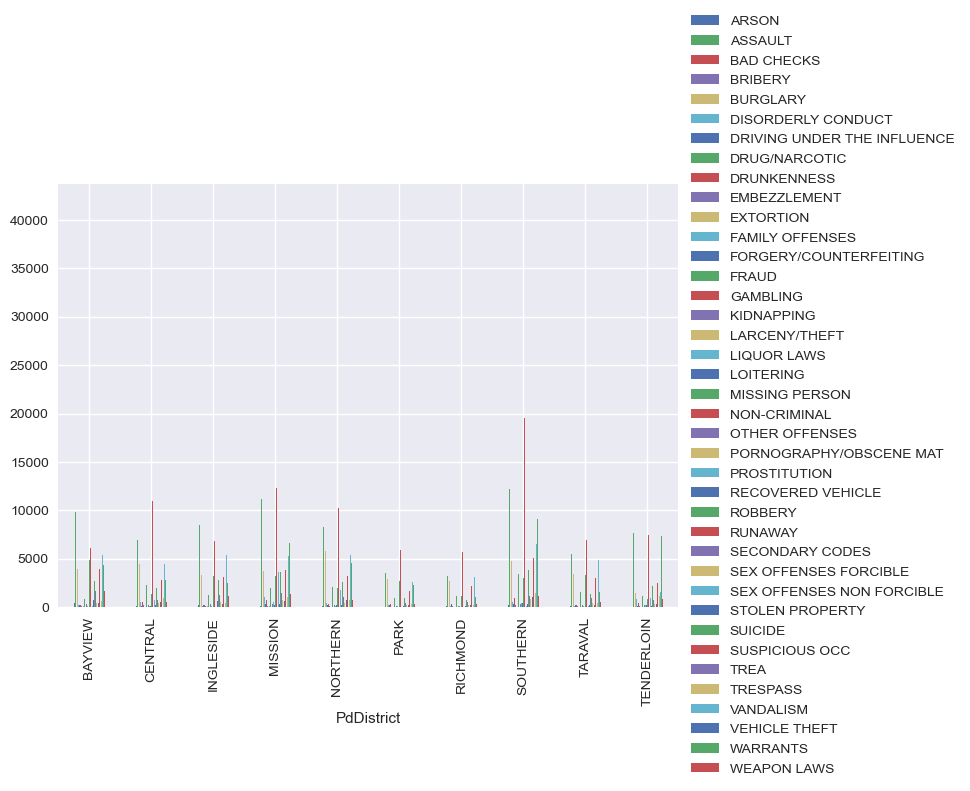

In [88]:
#Crimes per hour
#print(df_train_origin[['DayOfWeek','Category']].groupby(['DayOfWeek', 'Category']).size())
new_df = df_train_origin[['PdDistrict','Category']].groupby(['PdDistrict','Category']).size()
new_df = new_df
new_df.unstack('Category').plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In [ ]:
plt.style.use('seaborn')


df_train_origin['DayOfWeek'].value_counts().head(15).plot.pie(figsize = (15, 8), explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

plt.title('Crime count on each day',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

In [ ]:
#Crimes per hour

plt.figure(3, figsize=(14,10))
plt.style.use('seaborn')
plt.title('Number of crimes per hour')
plt.ylabel('Number of Crimes')
plt.xlabel('hour')


color = plt.cm.plasma(np.linspace(0, 1, 7))


X_df.groupby([X_df['hour']]).size().sort_values(ascending=True).plot(kind='bar', color=color)

plt.show()

In [ ]:
#Crimes per weekend

plt.figure(3, figsize=(14,10))
plt.style.use('seaborn')
plt.title('Number of crimes per weekend')
plt.ylabel('Number of Crimes')
plt.xlabel('weekend')

color = plt.cm.rainbow(np.linspace(0, 1, 7))

X_df.groupby([X_df['Weekend']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

In [ ]:
#Crimes per Address Type

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per Address-Type')
plt.ylabel('Number of Crimes')
plt.xlabel('Address-Type')


X_df.groupby([X_df['Address']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
X_df['hour'].value_counts().head(20).plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of crime over the day', fontsize = 20)
plt.show()

In [ ]:
df = pd.crosstab(df_train_origin['Category'], df_train_origin['PdDistrict'])
color = plt.cm.Greys(np.linspace(0, 1, 10))

df.div(df.sum(1).astype(float), axis = 0).plot.bar(stacked = True, color = color, figsize = (18, 12))
plt.title('District vs Category of Crime', fontweight = 30, fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

In [ ]:
t = df_train_origin.PdDistrict.value_counts()

table = pd.DataFrame(data=t.values, index=t.index, columns=['Count'])
table = table.reindex(["CENTRAL", "NORTHERN", "PARK", "SOUTHERN", "MISSION", "TENDERLOIN", "RICHMOND", "TARAVAL", "INGLESIDE", "BAYVIEW"])

table = table.reset_index()
table.rename({'index': 'Neighborhood'}, axis='columns', inplace=True)

table

In [ ]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('seaborn')

color = plt.cm.ocean(np.linspace(0, 1, 15))
df_train_origin['Address'].value_counts().head(15).plot.bar(color = color, figsize = (15, 10))

plt.title('Top 15 Regions in Crime',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

#### Preparing the models (normalization and splitting)
        

In [ ]:
mean = X_df.mean(axis=0)
std = X_df.std(axis=0)
X_df = (X_df - mean) / std
#x_test = (x_test_origin - mean) / std

In [ ]:
#Train- data split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_df, Y_df[0], train_size=0.8, random_state=0, stratify=Y_df[0])

print("training samples: ", x_train.shape[0])
print("test samples: ", x_test.shape[0])
print("sample dimension: ", x_train.shape[1])


In [ ]:
x_train = (x_train - x_train.mean())/ x_train.std() #immer Trainings Daten verwenden, auch bei den Testdaten

x_test = (x_test - x_train.mean())/ x_train.std()

#### Classifier: Neural Network

In [ ]:
#13 Input Layer; 1 Output Layer
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

model = Sequential()
'''
model.add(Input(shape=X_df.shape[1]))
model.add(Dense(120, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(120, activation='relu'))
model.add(Dense(39, activation='softmax'))
'''
model.add(Input(shape=X_df.shape[1]))
model.add(Dense(200, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(39, activation='softmax'))



model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
#model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#model.compile(loss='mean_squared_logarithmic_error', optimizer="adam", metrics=["accuracy"])


In [ ]:
history = model.fit(
  x_train,
  y_train,
  batch_size=200,
  epochs=20,
  validation_split=.2,
)

In [ ]:
import keras
def plot_history(history: keras.callbacks.History):
  """
  plot the training and validation loss for each training epoch

  history: a History object, output of the .fit method of a keras model
  """
  n = len(history.history['loss'])
  plt.plot(np.arange(n), history.history['loss'], label="training loss")
  plt.plot(np.arange(n), history.history['val_loss'], label="validation loss")
  plt.xticks(range(0, n + 1, 2))
  plt.legend()
  plt.show()

In [ ]:
plot_history(history)